In [409]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

let's load the first dataset as an example:

In [410]:
from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes, load_wine
from sklearn.model_selection import train_test_split

# data = load_iris()
data = load_breast_cancer()
# data = load_wine()
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(data['data']), data['target'], random_state=42)
X_train

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
287,12.890,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,13.620,15.54,87.40,577.0,0.09616,0.11470,0.11860,0.05366,0.2309,0.06915
512,13.400,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,16.410,29.66,113.30,844.4,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090
402,12.960,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,...,14.130,24.61,96.31,621.9,0.09329,0.23180,0.16040,0.06608,0.3207,0.07247
446,17.750,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,...,21.530,38.54,145.40,1437.0,0.14010,0.37620,0.63990,0.19700,0.2972,0.09075
210,20.580,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,...,23.240,27.84,158.30,1656.0,0.11780,0.29200,0.38610,0.19200,0.2909,0.05865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
106,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,13.140,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097
270,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,14.910,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,17.040,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550


lets create an automatic feature engineering class:

In [411]:
from sklearn.base import BaseEstimator, TransformerMixin

class AutoFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numerical_cols = []
        self.categorical_cols = []
        self.preprocessor = None
    
    def fit(self, X, y=None):
        # Separate numerical and categorical columns
        self.numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns
        self.categorical_cols = X.select_dtypes(include=["object"]).columns

        # Define preprocessing steps for numerical features
        numerical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler()),
            ('poly', PolynomialFeatures(degree=2))
        ])

        # Define preprocessing steps for categorical features
        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        # Combine preprocessing steps for all features
        self.preprocessor = ColumnTransformer(transformers=[
            ("num", numerical_transformer, self.numerical_cols),
            ("cat", categorical_transformer, self.categorical_cols)
        ])

        # Fit the preprocessor to the data
        self.preprocessor.fit(X)

        return self
    
    def transform(self, X):
        X_transformed = self.preprocessor.transform(X)
        return X_transformed


lets create an automatic feature selection class:

In [412]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, metric=accuracy_score):
        self.metric = metric
    
    def fit(self, X, y):
        n_features = X.shape[1]
        
        # Initialize SelectKBest and SelectFromModel transformers
        skb = SelectKBest(chi2, k=int(0.9 * n_features))
        sfm = SelectFromModel(RandomForestClassifier(n_estimators=1, random_state=0))
        
        # Fit both transformers to the data and calculate accuracy scores
        skb.fit(X, y)
        X_skb = skb.transform(X)
        acc_skb = self.metric(y, RandomForestClassifier(n_estimators=1, random_state=0).fit(X_skb, y).predict(X_skb))
        
        sfm.fit(X, y)
        X_sfm = sfm.transform(X)
        acc_sfm = self.metric(y, RandomForestClassifier(n_estimators=1, random_state=0).fit(X_sfm, y).predict(X_sfm))
        
        # Choose the better transformer based on accuracy score
        if acc_skb >= acc_sfm:
            print("Selecting features according to the k highest scores.")
            self.transformer = skb
        else:
            print("selecting features based on importance weights.")
            self.transformer = sfm
        
        # Fit the chosen transformer to the data
        self.transformer.fit(X, y)
        return self
    
    def transform(self, X):
        return self.transformer.transform(X)

we perform auto features engineering on both the train and the test datasets using our AutoFeatureEngineer class:

In [413]:
auto_fe = AutoFeatureEngineer()
X_train_transformed = auto_fe.fit_transform(X_train)
X_test_transformed = auto_fe.transform(X_test)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=auto_fe.preprocessor.get_feature_names_out())
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=auto_fe.preprocessor.get_feature_names_out())
X_train_transformed_df

,num__1,num__x0,num__x1,num__x2,num__x3,num__x4,num__x5,num__x6,num__x7,num__x8,...,num__x26^2,num__x26 x27,num__x26 x28,num__x26 x29,num__x27^2,num__x27 x28,num__x27 x29,num__x28^2,num__x28 x29,num__x29^2
0,1.0,0.254616,0.115320,0.241642,0.148245,0.152749,0.061331,0.052952,0.058201,0.090763,...,0.015237,0.022762,0.018103,0.014765,0.034003,0.027044,0.022057,0.021509,0.017543,0.014308
1,1.0,0.279593,0.365573,0.289657,0.165751,0.523337,0.436682,0.338566,0.406163,0.506674,...,0.282420,0.374559,0.211609,0.251660,0.496759,0.280646,0.333763,0.158552,0.188561,0.224250
2,1.0,0.258044,0.290159,0.257931,0.152235,0.188499,0.204130,0.095056,0.093588,0.377469,...,0.027870,0.037910,0.054036,0.024668,0.051565,0.073500,0.033554,0.104765,0.047827,0.021834
3,1.0,0.492629,0.619547,0.493527,0.348065,0.427372,0.383604,0.397844,0.412177,0.291511,...,0.443566,0.450871,0.184718,0.201620,0.458296,0.187760,0.204941,0.076923,0.083962,0.091645
4,1.0,0.631226,0.420358,0.617300,0.480391,0.345491,0.395247,0.384255,0.475199,0.319274,...,0.161486,0.265140,0.106464,0.012298,0.435328,0.174800,0.020192,0.070189,0.008108,0.000937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1.0,0.058622,0.166723,0.077323,0.031580,0.408053,0.457914,0.201640,0.142744,0.392419,...,0.022276,0.024547,0.020271,0.067515,0.027050,0.022337,0.074398,0.018446,0.061438,0.204627
422,1.0,0.193398,0.291512,0.193840,0.103879,0.555836,0.281899,0.165651,0.173211,0.338494,...,0.089414,0.125158,0.073149,0.091080,0.175190,0.102391,0.127490,0.059843,0.074513,0.092778
423,1.0,0.323179,0.240446,0.301465,0.198318,0.105263,0.025238,0.016987,0.031064,0.182061,...,0.001619,0.004609,0.007083,0.002101,0.013119,0.020162,0.005981,0.030987,0.009192,0.002727
424,1.0,0.307997,0.335137,0.307298,0.184116,0.481809,0.321622,0.263824,0.321223,0.268019,...,0.179353,0.265889,0.134739,0.181162,0.394177,0.199749,0.268570,0.101223,0.136098,0.182989


training a RandomForest Classifier on the baseline data, before performing features engineering or selection:

In [414]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1, random_state=0)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
score = sum(pred==y_test)/len(y_test)
print("The acuuracy of the initial model is:", score)

The acuuracy of the initial model is: 0.8951048951048951


now lets train the same classifier on the training set after performing feature engineering trasformation on the data:

In [415]:
forest.fit(X_train_transformed, y_train)
pred_fe = forest.predict(X_test_transformed)
score = sum(pred_fe==y_test)/len(y_test)
print("The accuracy of the model after feature engineering is:", score)

The accuracy of the model after feature engineering is: 0.951048951048951


lets see the performance of the classifier on the baseline data:

In [416]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        54
           1       0.95      0.88      0.91        89

    accuracy                           0.90       143
   macro avg       0.89      0.90      0.89       143
weighted avg       0.90      0.90      0.90       143



and here are the results for the tranformed data after feature engineering operations:

In [417]:
report = classification_report(y_test, pred_fe)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94        54
           1       0.98      0.94      0.96        89

    accuracy                           0.95       143
   macro avg       0.94      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



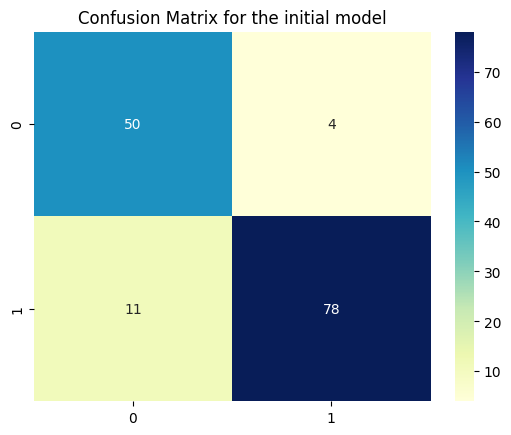

In [418]:
# confusion matrix for the initial model:
cm_arr = confusion_matrix(y_test, pred)
sns.heatmap(cm_arr, cmap='YlGnBu', annot=True, fmt="d").set_title('Confusion Matrix for the initial model')
plt.show()

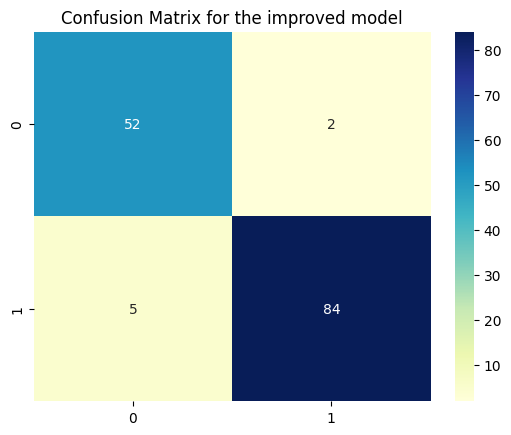

In [419]:
# confusion matrix for the improved model:
cm_arr = confusion_matrix(y_test, pred_fe)
sns.heatmap(cm_arr, cmap='YlGnBu', annot=True, fmt="d").set_title('Confusion Matrix for the improved model')
plt.show()

lets use the FeatureSelector class and perform feature selection operation:

In [420]:
selector = FeatureSelector()
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)

selecting features based on importance weights.


In [421]:
forest.fit(X_train_selected, y_train)
pred_fe_fs = forest.predict(X_test_selected)
score = sum(pred_fe_fs==y_test)/len(y_test)
print("The accuracy of the model after feature selection:", score)

The accuracy of the model after feature selection: 0.9440559440559441


now lets test it on more 3 different datasets:

dataset: Wine - The acuuracy of the initial model is: 0.8444444444444444
Selecting features according to the k highest scores.
dataset: Wine - The accuracy of the model after feature engineering and selection: 0.9111111111111111
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.76      0.89      0.82        18
           2       0.91      0.83      0.87        12

    accuracy                           0.84        45
   macro avg       0.86      0.84      0.85        45
weighted avg       0.85      0.84      0.85        45

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.89      0.89      0.89        18
           2       1.00      0.92      0.96        12

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.92        45
weighted avg       0.91      0.91      0.91        45



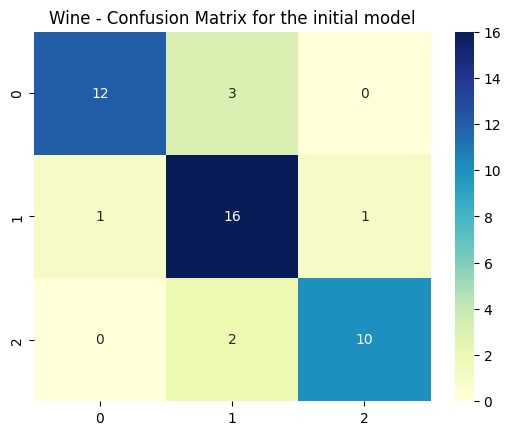

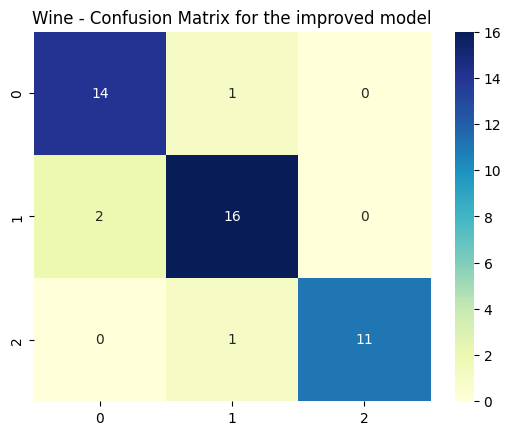

dataset: breast_cancer - The acuuracy of the initial model is: 0.8951048951048951
selecting features based on importance weights.
dataset: breast_cancer - The accuracy of the model after feature engineering and selection: 0.9440559440559441
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        54
           1       0.95      0.88      0.91        89

    accuracy                           0.90       143
   macro avg       0.89      0.90      0.89       143
weighted avg       0.90      0.90      0.90       143

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        54
           1       0.97      0.94      0.95        89

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



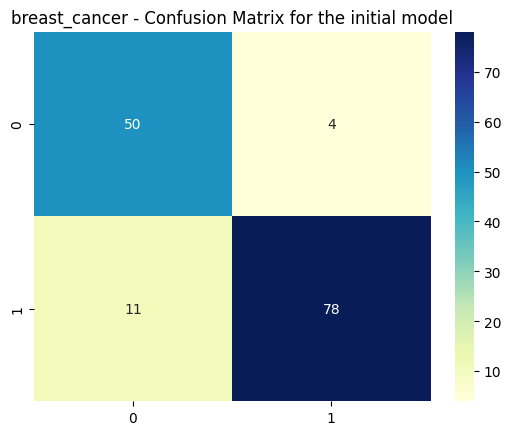

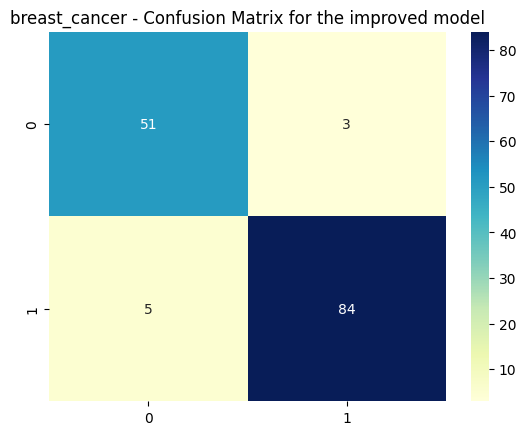

dataset: iris - The acuuracy of the initial model is: 0.9736842105263158
selecting features based on importance weights.
dataset: iris - The accuracy of the model after feature engineering and selection: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



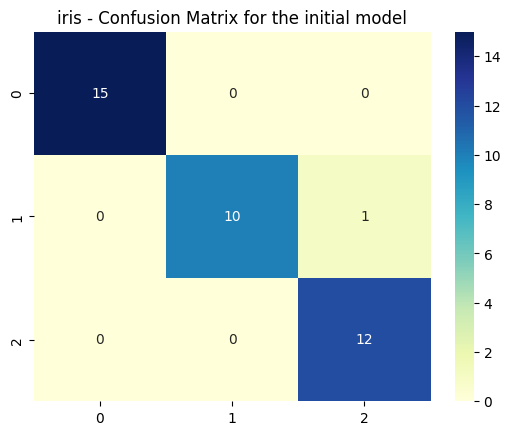

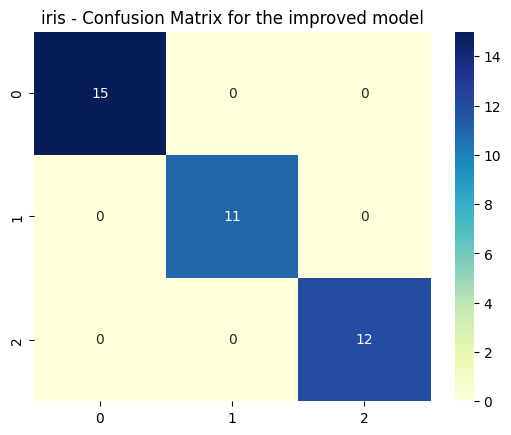

In [422]:
from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes, load_wine

def evaluate_dataset(data, dataset_name, datasetSource):
    if datasetSource == "sklearn":
        # split the current dataset into train and test parts:
        X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(data['data']), data['target'], random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(data["x"], data["y"], test_size=0.2, random_state=42)

    # performing auto feature engineering operations on the dataset:
    auto_fe = AutoFeatureEngineer()
    X_train_transformed = auto_fe.fit_transform(X_train)
    X_test_transformed = auto_fe.transform(X_test)

    # train a classifier on the baseline dataset (before augmenting the data)
    forest = RandomForestClassifier(n_estimators=1, random_state=0)
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    score = sum(pred==y_test)/len(y_test)
    print("dataset: {} - The acuuracy of the initial model is: {}".format(dataset_name, score ))

    # perform feature selection on the dataset after already performing feature engineering
    selector = FeatureSelector()
    X_train_selected = selector.fit_transform(X_train_transformed, y_train)
    X_test_selected = selector.transform(X_test_transformed)

    forest.fit(X_train_selected, y_train)
    pred_fe_fs = forest.predict(X_test_selected)
    score_fe_fs = sum(pred_fe_fs==y_test)/len(y_test)
    print("dataset: {} - The accuracy of the model after feature engineering and selection: {}".format(dataset_name, score_fe_fs ))

    # reports:
    report = classification_report(y_test, pred)
    print(report)
    
    report = classification_report(y_test, pred_fe_fs)
    print(report)

    cm_arr = confusion_matrix(y_test, pred)
    sns.heatmap(cm_arr, cmap='YlGnBu', annot=True, fmt="d").set_title('{} - Confusion Matrix for the initial model'.format(dataset_name))
    plt.show()

    cm_arr = confusion_matrix(y_test, pred_fe_fs)
    sns.heatmap(cm_arr, cmap='YlGnBu', annot=True, fmt="d").set_title('{} - Confusion Matrix for the improved model'.format(dataset_name))
    plt.show()

dataset1 = load_wine()
evaluate_dataset(dataset1, "Wine", datasetSource="sklearn")

dataset2 = load_breast_cancer()
evaluate_dataset(dataset2, "breast_cancer", datasetSource="sklearn")

dataset3 = load_iris()
evaluate_dataset(dataset3, "iris", datasetSource="sklearn")

# for dataset4 I chose the titanic dataset from seaborn.
# for the titanic dataset we needed to perform one-hot encoding to convert all the categorial,
#  in addition there are missing values in the input data and there was a need to impute the missing values.
# this is exactly what our solution solves, without aoutomating the process there was a need to perform all the mentioned actions manualy.
